   file    bx    by    bz    bl    bm    bn  bmag      vx      vy     vz  \
0    55  0.52  3.99 -2.53  0.12 -4.74 -0.33  4.75 -212.49  126.52  94.29   
1    55 -0.46  2.83 -0.37  1.47 -2.49 -0.08  2.89 -205.30  121.80  91.70   
2    55  0.63  3.69 -2.23  0.10 -4.36 -0.12  4.36 -208.85  119.43  89.61   

     vmag    np    tpar    tper  goal  
0  264.67  5.51  141.67  157.74     2  
1  255.72  6.51  139.22  154.13     2  
2  256.73  6.15  144.39  151.92     2  


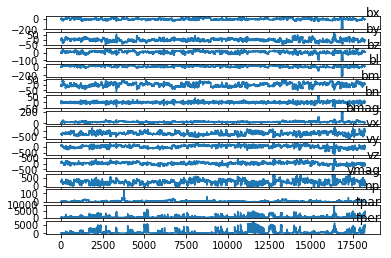

In [43]:
import numpy as np
import tensorflow as tf

from pandas import read_excel

from matplotlib import pyplot

#Loading the raw dataset
dataset = read_excel("challenge_dataset.xlsx", usecols="B:Q")

values = dataset.values

# Lets print the first 3 rows of the dataset
print(dataset.head(3))

#Lets create a quick plot of each series (as a separate subplot) and see what we have
i = 0
Nc = 14 #plotting columns 1 to 14
pyplot.figure()
for group in range(1,Nc+1):
    i += 1
    pyplot.subplot(Nc, 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
pyplot.show()


In [53]:
# ensuring all the data is float
values = values.astype('float32')

# normalizing features (columns 1 to 14) NOTE: column 15 = goal (three classes: 0, 1, 2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values[:,0:15])
#scaled = values[:,0:15]

import pandas as pd
df = pd.DataFrame(scaled)

print("values.shape =", values.shape)
print("df.shape     =", df.shape)
#print('df:', df.head())
#print('dataset:', dataset.head())


values.shape = (18245, 16)
df.shape     = (18245, 15)


In [54]:
# split the data into train and test sets
# taking 80% of the data for training
n_train = 89 * int( values.shape[0]/89 * 0.80) #each time series has 89 entities

last_column = values.shape[1] - 1 #last column (goal) in he raw dataset

# inputs
train_X = scaled[:n_train, :]
test_X  = scaled[n_train:, :]
# outpts
train_y = values[:n_train, last_column]
test_y  = values[n_train:, last_column]

# reshape input data to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape( (test_X.shape[0],  1, test_X.shape[1]))
print("train_X.shape =", train_X.shape)
print("train_y.shape =", train_y.shape)
print("test_X.shape  =", test_X.shape)
print("test_y.shape  =", test_y.shape)


train_X.shape = (14596, 1, 15)
train_y.shape = (14596,)
test_X.shape  = (3649, 1, 15)
test_y.shape  = (3649,)


Train on 14596 samples, validate on 3649 samples
Epoch 1/10
 - 2s - loss: 0.4503 - mean_squared_logarithmic_error: 0.4503 - mean_absolute_error: 1.0125 - val_loss: 0.2099 - val_mean_squared_logarithmic_error: 0.2099 - val_mean_absolute_error: 0.7013
Epoch 2/10
 - 0s - loss: 0.1886 - mean_squared_logarithmic_error: 0.1886 - mean_absolute_error: 0.6854 - val_loss: 0.2277 - val_mean_squared_logarithmic_error: 0.2277 - val_mean_absolute_error: 0.7136
Epoch 3/10
 - 0s - loss: 0.1784 - mean_squared_logarithmic_error: 0.1784 - mean_absolute_error: 0.6580 - val_loss: 0.2372 - val_mean_squared_logarithmic_error: 0.2372 - val_mean_absolute_error: 0.7179
Epoch 4/10
 - 0s - loss: 0.1740 - mean_squared_logarithmic_error: 0.1740 - mean_absolute_error: 0.6434 - val_loss: 0.2428 - val_mean_squared_logarithmic_error: 0.2428 - val_mean_absolute_error: 0.7199
Epoch 5/10
 - 0s - loss: 0.1711 - mean_squared_logarithmic_error: 0.1711 - mean_absolute_error: 0.6331 - val_loss: 0.2456 - val_mean_squared_logari

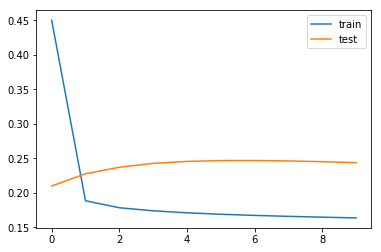

In [61]:
#import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras import optimizers

# designing the network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Activation('softmax'))
model.add(Dense(1))

np.random.seed(3)

opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

### optimizer='adam', loss='categorical_accuracy', metrics=['accuracy']
model.compile(optimizer=opt, loss='msle', metrics=['msle', 'mae'])

# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()